This is an example of how we can use pre-trained CNN in order to generate recommendations.

Today we will work on the fashion dataset

# Imports

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import seaborn as sns

# Mount google drive
from google.colab import drive

# Load Data

In [2]:
#Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_PATH = "/content/drive/My Drive/Recommender Systems/Datasets/Fashion/"
os.chdir(DATASET_PATH)

In [ ]:
#Needed only if you did not unzip this dataset before. 
!unzip 'images.zip'

Let's take a look at the data. For convenience reasons, we will use only the first 4000 images. However, you can edit this number and use all ~44k images available. 

Notably, using all images can lead to more accurate and diverse recommendations. Nonetheless, generating recommendations based on the similarities to all images will take much more time when considering a higher amount of images.

In [5]:
df = pd.read_csv(DATASET_PATH + "styles.csv",nrows=4000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Unnamed: 10,Unnamed: 11,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,NaN,NaN,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,NaN,NaN,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,NaN,NaN,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,NaN,NaN,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,NaN,NaN,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,NaN,NaN,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,NaN,NaN,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,NaN,NaN,30039.jpg


First, we will perform some basic EDA to understand the data better

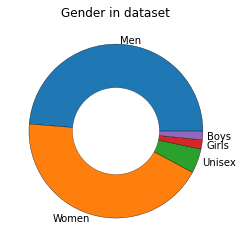

In [6]:
gender_count = df['gender'].value_counts()

fig, ax = plt.subplots()

ax.pie(gender_count.values,
        labels=gender_count.index,
#         autopct='%1.1f%%',
        wedgeprops={'linewidth': 0.33, 'edgecolor': 'black'},        
        labeldistance=1.05, # remove the wedge labels
       
        )

centre_circle = plt.Circle((0,0), 0.5, edgecolor='black', 
facecolor='white',fill=True,linewidth=0.25)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.title('Gender in dataset')
plt.show()

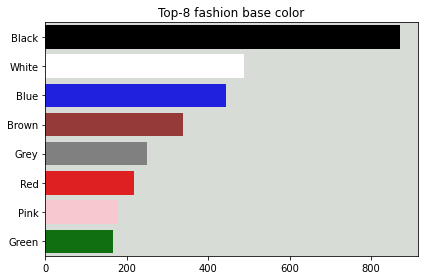

In [7]:
color_count = df['baseColour'].value_counts()[:8]


ax = sns.barplot(x=color_count.values,
            y=color_count.index,
            palette = color_count.index)

ax.set_facecolor('xkcd:light grey')

plt.title('Top-8 fashion base color')
plt.tight_layout()
plt.show()

In [28]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(6, 6)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):        
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()    
    
def img_path(img):
    """return the image path.

    Parameters
    ----------
    img : image number    
    """
    return DATASET_PATH+"images/"+img

def load_image(img):
    """ load image.

    Parameters
    ----------
    img : image number    
    """
    img     = cv2.imread(img_path(img))    
    return img

def show_image(img):
    """ display image utilizing matplotlib

    Parameters
    ----------
    img : image number    
    """
    x = load_image(img)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    plt.imshow(x)
    plt.axis('off')
    plt.show()

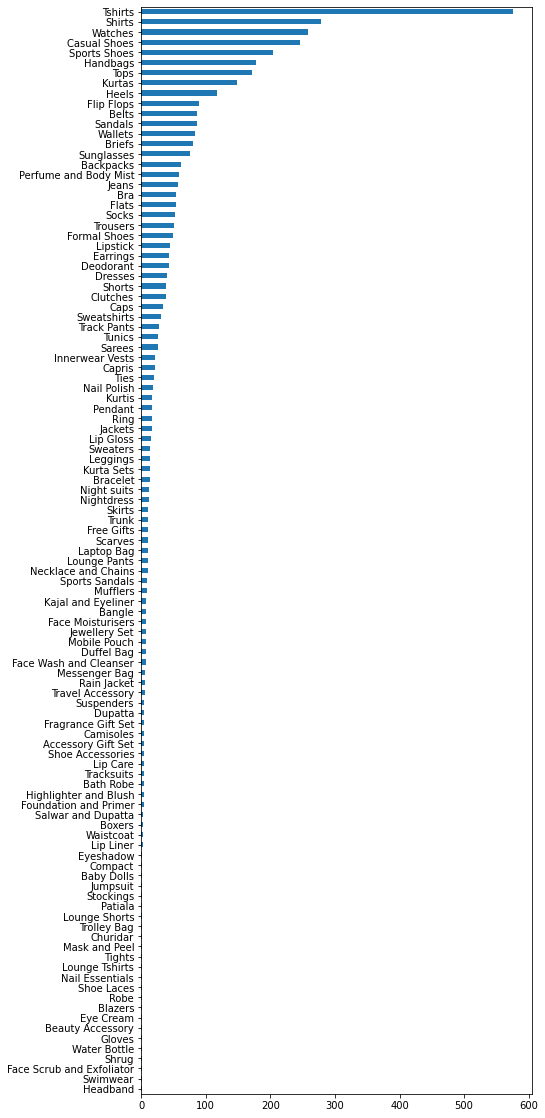

In [29]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

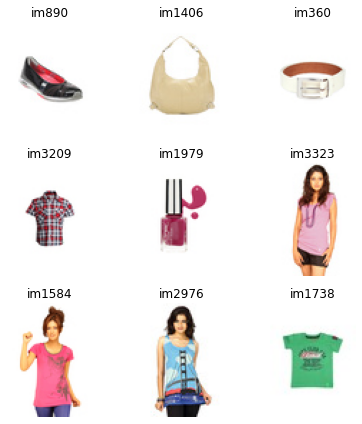

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(9).iterrows()}
# plot of the images in a figure, with 3 rows and 3 columns
plot_figures(figures, 3, 3)
plt.tight_layout()
plt.show()

Next, we will install the following ''efficientnet'' package, which implements many state-of-the-art architectures, including ''imagenet''.

We will use the weights of ''imagenet'', and set the model trainable property to false. (No parameters are updated during training)

In [10]:
!pip install -q efficientnet


     |████████████████████████████████| 51kB 7.8MB/s 


In [11]:
from efficientnet.tfkeras import EfficientNetB3

efficientnet_model = EfficientNetB3(weights='imagenet',
                                        include_top=False,
                                        pooling='max')

efficientnet_model.trainable = False

efficientnet_model.summary()

44113920/44107200 [==============================] - 0s 0us/step
Model: "efficientnet-b3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
___________________

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input


def get_embedding(model, image):
    """get ambedding of image

    Parameters
    ----------
    model : deep learning model such as imagenet    
    image : image number
    """
    # img_path = 'images/'+ image
    path = img_path(image)
    
    img = load_img(path, target_size=(300, 300))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    
    return model.predict(img).reshape(-1)

Let's consider an example of an image. 
We will display this image and it's embeddings.

Image shape after embedding: (1536,)
[2.692224  3.8664627 5.9367847 ... 3.954986  7.0771017 1.3235631]


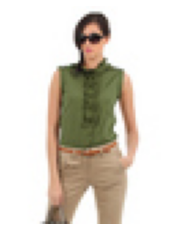

CPU times: user 3.78 s, sys: 940 ms, total: 4.72 s
Wall time: 32.1 s


In [32]:
%%time
item_idx = 555
img_embed = get_embedding(efficientnet_model, df.iloc[item_idx].image)
print('Image shape after embedding:', img_embed.shape)
print(img_embed)
show_image(df.iloc[item_idx].image)

Now, we will apply this techniques for all images

In [15]:
%%time
map_embeddings = df['image'].apply(lambda img_path: get_embedding(efficientnet_model, img_path))


CPU times: user 3min 52s, sys: 6.54 s, total: 3min 59s
Wall time: 19min


In [16]:
df_embs = map_embeddings.apply(pd.Series)

We will evaluate the distance between the embeddings with the following code:

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.79397804, 0.5925066 , 0.77241457],
       [0.79397804, 1.        , 0.5671795 , 0.85204947],
       [0.5925066 , 0.5671795 , 0.99999964, 0.59718853],
       [0.77241457, 0.85204947, 0.59718853, 1.        ]], dtype=float32)

In [18]:
indices = pd.Series(range(len(df)), index=df.index)

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx,top_n = 5):
    """generate top_n recommendation for a given index.
    Function: Give a recommendation based on similarity between product image    

    Parameters
    ----------
    idx : index of an image 
    top_n : number of recommendations to retrieve
    """
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(5, top_n = 5)

(Int64Index([3259, 3953, 2126, 3938, 976], dtype='int64'),
 [0.9572412, 0.94674647, 0.94562495, 0.9427997, 0.94187737])

In [19]:
def show_recommender(idx,top_n=3):    
    '''
    Display the recommendations utilizing get_recommender function.

    Parameters
    ----------
    idx : index of an image 
    top_n : number of recommendations to retrieve    
    '''  
    # Recommendations
    idx_rec, idx_sim = get_recommender(idx,top_n=top_n)

    # Plot        
    show_image(df.iloc[idx].image)
    plt.title(df.iloc[idx].productDisplayName)
    plt.axis('off')

    # generation of a dictionary of (title, images)
    #figures = {'im ' + str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
    figures = {row.productDisplayName: load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}

    # plot of the images in a figure, with 2 rows and 3 columns
    plot_figures(figures,nrows=3,ncols=1) 

Let's see two examples of the use of the recommendations generated by these functions.

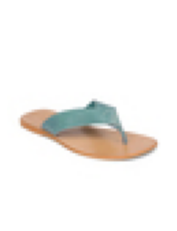

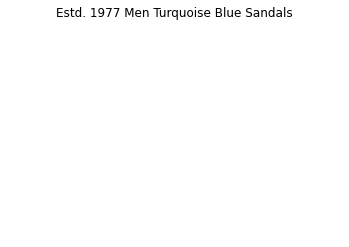

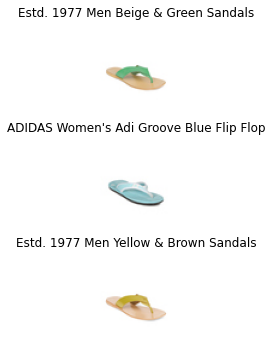

In [20]:
show_recommender(879)


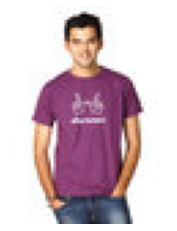

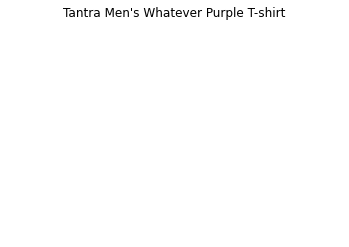

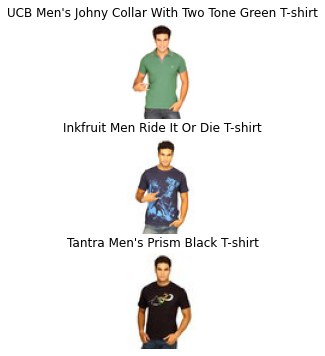

In [21]:
show_recommender(531)


Moreover, we aim in explorint the embedding in space. 
Therefore, we will use TSNE and perform clustering on the masterCatergory and subCategory

In [22]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [23]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 67.17950916290283 seconds


In [24]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

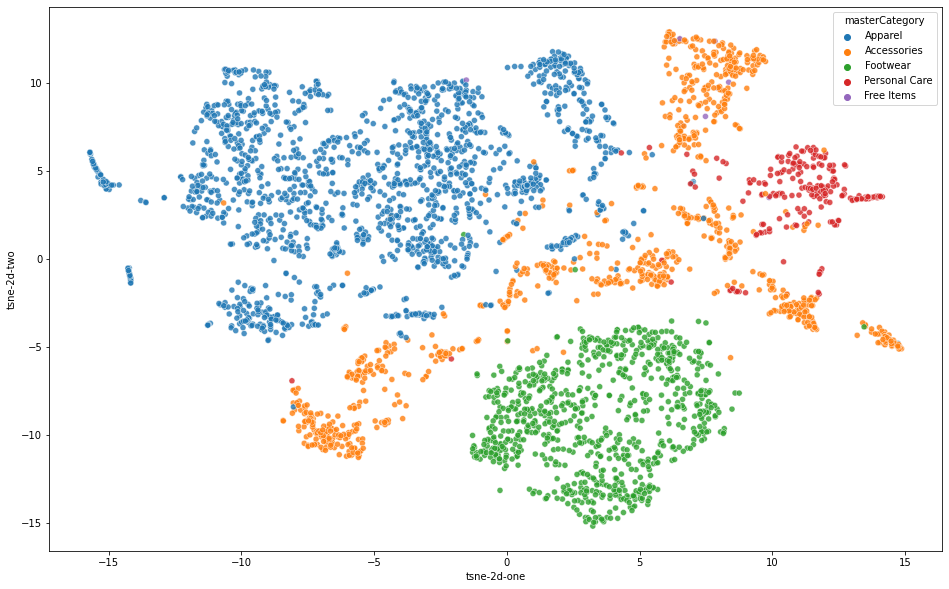

In [25]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

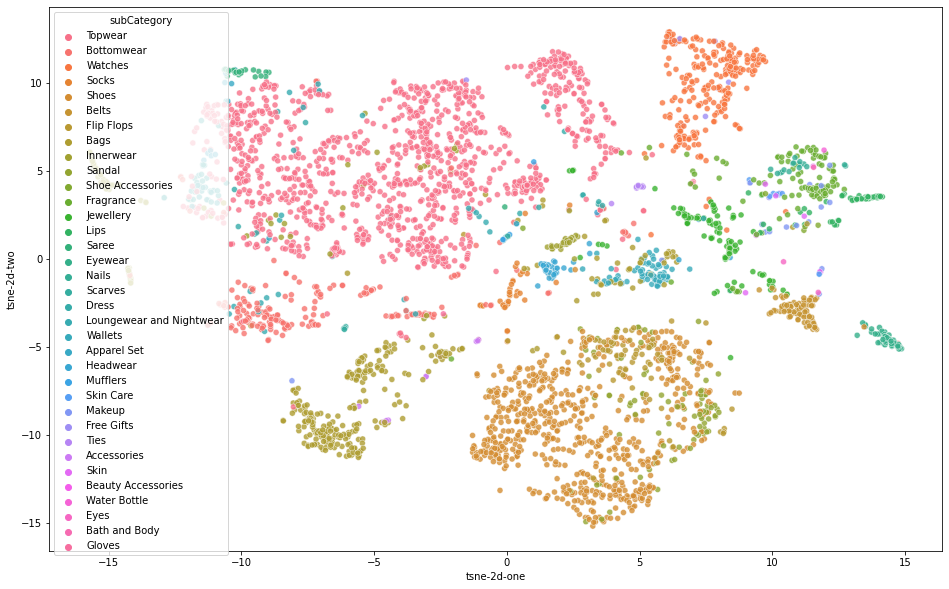

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

Not surprisingly, we can observe that similar categories (i.e., footwear) are embedding close to each other in space.